In [121]:
import numpy as np
#import pytorch as pt
from scipy.sparse import diags, lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt


delta_t = 0.1 #time step
eta = 1 # 0.1
M = 1
gamma = 0.05
epsilon = 1 # 0.04
Re = 1
rho = 1/Re
m = 5 #grid point
x_0, x_m = 0, 1
y_0, y_m = 0, 1
h = (x_m - x_0) / (m)
t_e = 5
T = 10
C0 = 0

In [124]:
x, delta_x = np.linspace(x_0, x_m, m+1, retstep = True)
y, delta_y = np.linspace(y_0, y_m, m+1, retstep = True)
X, Y = np.meshgrid(x[0:m], y[0:m], indexing = 'ij')

x_mod = np.zeros(m**2)
y_mod = y[0:m]
for i in range(m-1):
    x_mod[i*m : i*m+m] = x[i]
    y_mod = np.vstack((y_mod, y[0:m]))
y_mod = y_mod.flatten()


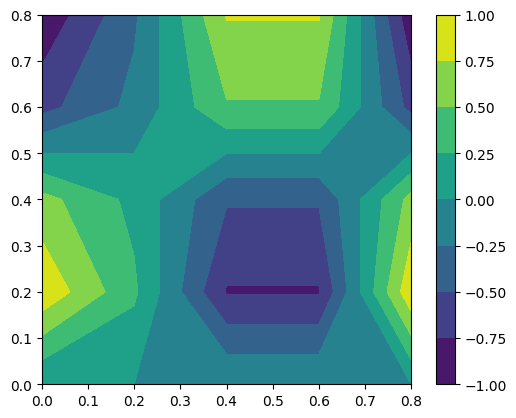

In [125]:
phi_init_ = np.cos(2*np.pi*x_mod)*np.sin(2*np.pi*y_mod)
phi_plot = np.reshape(phi_init_, (m, m))
plt.contourf(X, Y, phi_plot)
plt.axis('scaled')
plt.colorbar()
plt.show()

In [126]:
def f_0(phi, epsilon):
    return 1./(4*epsilon**2) * (1-phi**2)**2

#function to calculate f_0^prime
def f_0_prime(phi, epsilon):
    return -(1-phi**2)*phi/epsilon**2

def E(phi, m, h):
    #gradient of phi wrt x
    gradx_phi = gradient_mat(m, h,np.ones((m**2, 1)), 1, 'x').dot(phi)
    #gradient of phi wrt y
    grady_phi = gradient_mat(m,h,np.ones((m**2, 1)), 1, 'y').dot(phi)
    #square of norm of grad phi
    norm_grad_phi = 1/2*(np.square(gradx_phi) + np.square(grady_phi))
    f0 = f_0(phi, epsilon)
    #integrand
    integrand = f0 + norm_grad_phi
    #perform integration
    w_B = 0.5*h*h #boundary values' weight
    w = h*h #weight of inner grids' value
    w_C = 0.25*h*h #corner values' weight
    integral = 0
    for i in range(m**2):
        if i == 0 or i == m-1 or i == m**2-m or i == m**2-1:
            integral += integrand[i] * w_C
        elif i < m or i > m**2-m or i % m == 0 or i % m == m-1:
            integral += integrand[i] * w_B
        else:
            integral += integrand[i] * w
    return integral
    
def mu_init(phi, epsilon):
    #print(poisson_des(m, h, -1).shape)
    #print(phi.shape)
    poisson_term = poisson_des(m, h, -epsilon**2).dot(phi)
    nonlinear_term = f_0_prime(phi, epsilon)
    return poisson_term + nonlinear_term

def poisson_des(m, h, s):
    laplacian = lil_matrix((m**2, m**2))
    laplacian.setdiag(-4*np.ones(m**2)/(h**2))
    for i in range(m**2):
        if i % m != 0:
            laplacian[i,i-1] = 1/(h**2) * s
        if (i+1) % m != 0:
            laplacian[i, i+1] = 1/(h**2) * s
    for i in range(m**2 - m):
        laplacian[i, i+m] = 1/(h**2) * s
        laplacian[i+m, i] = 1/(h**2) * s

    for i in range(m):
        laplacian[i, m*(m-1)+i] = s/(h**2)
        laplacian[m*(m-1)+i, i] = s/(h**2)

    # Connect the first and last columns
    for i in range(m):
        laplacian[i*m, (i+1)*m-1] = s/(h**2)
        laplacian[(i+1)*m-1, i*m] = s/(h**2)
    return laplacian.tocsr()

#function to build gradient matrix and also deal with the convection term
def gradient_mat(m, h, u, s, x_or_y):
#u is the first operand of the convection term (u,grad(x)), u size m**2x1
#u is a vector for the inner product with the gradient matrix
#s is a scalar to be multiplied to the gradient matrix
#x_or_y indicate it's gradient wrt x or wrt y
    if (x_or_y == 'x'):
    #x-component of gradient (gradient along x)
        grad = lil_matrix((m**2, m**2))
        for i in range(m):
            for j in range(m-2):
                grad[i*m+j+1, i*m+j] = -s/(2*h) * u[i*m+j+1]
                grad[i*m+j+1, i*m+j+2] = s/(2*h) * u[i*m+j+1]
        for i in range(m):
            grad[i*m, i*m] = -3*s/(2*h) * u[i*m]
            grad[i*m, i*m+1] = 4*s/(2*h) * u[i*m]
            grad[i*m, i*m+2] = -s/(2*h) * u[i*m]
            grad[(i+1)*m-1, (i+1)*m-1] = 3*s/(2*h) * u[(i+1)*m-1]
            grad[(i+1)*m-1, (i+1)*m-2] = -4*s/(2*h) * u[(i+1)*m-1]
            grad[(i+1)*m-1, (i+1)*m-3] = s/(2*h) * u[(i+1)*m-1]
        return grad.tocsr()
    else:
    #y-component of gradient (gradient along y)
        grad = lil_matrix((m**2, m**2))
        #first and last row of grid points
        for i in range(m):
            #first row
            grad[i, i] = -3*s/(2*h) * u[i]
            grad[i, m+i] = 4*s/(2*h) * u[i]
            grad[i, 2*m+i] = -s/(2*h) * u[i]
            #last row
            grad[m*m-1-i, m*m-1-i] = 3*s/(2*h) * u[m*m-1-i]
            grad[m*m-1-i, m*m-1-i-m] = -4*s/(2*h) * u[m*m-1-i]
            grad[m*m-1-i, m*m-1-i-2*m] = s/(2*h) * u[m*m-1-i]
        #middle rows of grid points
        for i in range((m-2)*m):
            grad[i+m, i] = -s/(2*h) * u[i+m]
            grad[i+m, i+2*m] = s/(2*h) * u[i+m]
        return grad.tocsr()

def scalar_mul(s, m):
#s is the scalar, m is the size
    scalar = lil_matrix((m**2, m**2))
    for i in range(0, m**2):
        scalar[i, i] = s
    #return csr_matrix(scalar)
    return scalar#TODO

#function for calculating divergence
#u is a vector with 2 components (2D array)
def div_val(m, h, u, s):
    div_x = gradient_mat(m, h, np.ones(m**2), s, 'x')
    div_y = gradient_mat(m, h, np.ones(m**2), s, 'y')
    div = div_x.dot(u[0,:]) + div_y.dot(u[1,:])
    return div

#function to generate biharmonic discretization matrix
def biharmonic(m, h, s):
    poisson = poisson_des(m, h, s)
    biharmonic = csr_matrix(poisson.dot(poisson))
    return biharmonic

def Euler_one_step(m, h, delta_t, M, p, phi, rho, eta, \
                epsilon, C0):
    # first, calculate phi_mid, b_n and r
    phi_mid = helper_phi_mid(m, h, delta_t, phi)
    b_n = helper_b(m, h, phi_mid, C0)
    r = helper_r(m, h, phi, C0)
    # then solve for phi_n+1
    phi_n = phi/4
    phi_n_minus = np.zeros(m**2)
    phi_n_plus = solve_phi(m, h, delta_t, M, epsilon, phi_n, \
                phi_n_minus, b_n, C0) #this is phi_n+1

    return p, phi_n_plus

def BDF2_one_step(m, h, delta_t, M, p, phi_n, phi_n_minus,\
            rho, eta, epsilon, C0):
    # first, calculate phi_mid, b_n and r
    phi_mid = helper_phi_mid(m, h, delta_t, phi_n)
    b_n = helper_b(m, h, phi_mid, C0)
    r = helper_r(m, h, phi_n, C0)
    # then solve for phi_n+1
    phi_n_plus = solve_phi(m, h, delta_t, M, epsilon, phi_n, \
                phi_n_minus, b_n, C0) #this is phi_n+1

    return p, phi_n_plus

def time_stepping(m, h, delta_t, t_e, T, x, y, eta, rho, epsilon, M, C0):
    #calculate the initial values
    mu_init_ = mu_init(phi_init_, epsilon)
    p_init_ = p_init(phi_init_, mu_init_, eta, rho, m, h)
    # changing the initial pressure TODO
    #p_init_ = np.zeros(m**2)

    #start time stepping
    #first do Euler time stepping 10 times
    delta_t_euler = delta_t / t_e
    p = p_init_
    print("p_init_;", p_init_)#TODO

    phi_n_minus = phi_init_
    phi_n = phi_init_
    print("phi_init", phi_init_)


    for i in range(t_e):
        if i == 0:
            p, phi_n = Euler_one_step(m, h, delta_t_euler, M, \
                    p, phi_n_minus, rho, eta, epsilon, C0)
            continue
        print("i: ", i)#TODO
        p, phi = BDF2_one_step(m, h, delta_t_euler, M, \
                p, phi_n, phi_n_minus, rho, eta, \
                epsilon, C0)
        #update n_minus and n variables
        phi_n_minus = phi_n
        phi_n = phi

        phi_plot = np.reshape(phi, (m,m))
        plt.contourf(X, Y, phi_plot)
        plt.axis('scaled')
        plt.title(f"phi {i}")
        plt.colorbar()
        plt.show()

    for i in range(T - 1):
        print("i", i)
        if i == 0:
            phi_n_minus = phi_init_
        p, phi = BDF2_one_step(m, h, delta_t, M, p,\
                phi_n, phi_n_minus, rho, eta, epsilon, C0)
        #update n_minus and n variable
        phi_n_minus = phi_n
        #print("u_n vetor:", u_n)
        phi_n = phi

        phi_plot = np.reshape(phi, (m,m))
        plt.contourf(X, Y, phi_plot)
        plt.axis('scaled')
        plt.title(f"phi {i}")
        plt.colorbar()
        plt.show()

    return p, phi_n

def plotting(m, h, delta_t, t_e, T, x, y, eta, rho, epsilon, M, C0):
    p, phi = time_stepping(m, h, delta_t, t_e, T, x, y, eta, \
                        rho, epsilon, M, C0)
    phi_plot = np.reshape(phi, (m, m))
    plt.contourf(X, Y, phi_plot)
    plt.axis('scaled')
    plt.title('phi_final')
    plt.colorbar()
    plt.show()

def helper_mu(m, h, phi_n, epsilon, C0):
    poisson_phi = poisson_des(m, h, -epsilon**2).dot(phi_n)
    r = helper_r(m, h, phi_n, C0)
    f_term = r * helper_b(m, h, phi_n, C0)
    return poisson_phi + f_term

def p_init(phi, mu, eta, rho, m, h):#TODO
    #LHS-grad p
    grad = poisson_des(m, h, 1)
    
    #terms involving phi and mu
    grad_phi_x = gradient_mat(m, h, np.ones(m**2), -1, 'x').dot(phi)
    grad_phi_y = gradient_mat(m, h, np.ones(m**2), -1, 'y').dot(phi)
    #print(grad_phi_x.shape)#TODO
    grad_mu_x = gradient_mat(m, h, grad_phi_x, 1, 'x').dot(mu)
    grad_mu_y = gradient_mat(m, h, grad_phi_y, 1, 'y').dot(mu)
    grad_mu_term = grad_mu_x + grad_mu_y
    poisson_mu = poisson_des(m, h, -1).dot(mu) * phi

    RHS = poisson_mu + grad_mu_term 
    #solve for p_initial
    p = spsolve(grad, RHS)
    return p

    
#function to solve phi after solving u_hat_n+1
#This function is using u_hat as u_n+1 and not the real u_n+1 when
#solving for phi. TODO
def solve_phi(m, h, delta_t, M, epsilon, phi_n,\
            phi_n_minus, b, C0):
    #RHS
    b_phi_ip, RHS_2 = b_phi_inner_product(m, h, delta_t, M, \
        epsilon, phi_n, phi_n_minus, b, C0)

    first_term_coef = M/2 * b_phi_ip
    poisson_b = poisson_des(m, h, 1).dot(b) * first_term_coef
    RHS_1 = A_inverse_b(m, h, delta_t, M, epsilon, poisson_b)
    RHS = RHS_1 + RHS_2
    return RHS #phi_n+1 equals RHS

def gamma(m, h, delta_t, M, epsilon, b):
    poisson_b = poisson_des(m, h, 1).dot(b)
    A_term = A_inverse_b(m, h, delta_t, M, epsilon, poisson_b)
    return -M/2 * A_term * b

#helper: compute <b, phi_n+1>, it will also return A^-1*g
def b_phi_inner_product(m, h, delta_t, M, epsilon, phi_n,\
                        phi_n_minus, b, C0):
    #RHS (g_term)
    #div_u_hat = div_val(m, h, u_hat, -1/2)
    #scalar_phi = (2/delta_t + div_u_hat) * phi_n
    scalar_phi = (2/delta_t) * phi_n
    # divergence phi term
    #div_phi = div_val(m, h, phi_n, -1)
    #u_div_phi = (u_hat + u_n_minus)/2 * div_phi
    # phi_n-1 term
    scalar_phi_minus = -phi_n_minus/(2*delta_t)
    # laplacian b term
    r = helper_r(m, h, phi_n, C0)
    r_minus = helper_r(m, h, phi_n_minus, C0)
    laplacian_b_coef = 4*M/3*r - 2*M/3*(b*phi_n) + M/6*(b*phi_n_minus)\
        - M/3*r_minus
    laplacian_b = poisson_des(m, h, 1).dot(b) * laplacian_b_coef

    g = scalar_phi + scalar_phi_minus + laplacian_b
    A_inverse_g = A_inverse_b(m, h, delta_t, M, epsilon, g)

    RHS = A_inverse_g * b
    #LHS
    LHS = 1 + gamma(m, h, delta_t, M, epsilon, b)

    result = RHS/LHS
    return result, A_inverse_g

def helper_phi_mid(m, h, delta_t, phi_n):
    #LHS 
    #scalar term
    identity = scalar_mul(1,m)
    #biharmonic term
    biharmonic_ = biharmonic(m, h, delta_t)
    #print("biharmonic:", biharmonic_.shape)
    #print("idnetity:", identity.shape)
    LHS = biharmonic_ + identity
    #RHS
    f_prime = poisson_des(m, h, delta_t).dot(f_0_prime(phi_n, epsilon))
    RHS = f_prime + phi_n
    #solve for phi_middle
    phi_mid = spsolve(LHS, RHS)
    return phi_mid

#helper function to calculate r
def helper_r(m, h, phi_n, C0):
    #f_0_n = f_0(phi_n, epsilon)
    r = np.sqrt(E(phi_n, m, h) + C0)
    return r

#helper function to solve b_n
def helper_b(m, h, phi_mid, C0):
    numerator = f_0_prime(phi_mid, epsilon)
    #f_0_mid = f_0(phi_mid, epsilon)
    denominator = np.sqrt(E(phi_mid, m, h)+C0)
    return numerator / denominator

#helper: solve Ax=(b)
def A_inverse_b(m, h, delta_t, M, epsilon, poisson_b):
    #LHS (A)
    scalar_ = scalar_mul(3/(2*delta_t), m)
    biharmonic_ = biharmonic(m, h, M*epsilon**2)
    A = scalar_ + biharmonic_
    #solve for A_inverse_poisson_b
    result = spsolve(A, poisson_b)
    return result


p_init_; [1.80065837e+19 1.80065837e+19 1.80065837e+19 1.80065837e+19
 1.80065837e+19 1.80065837e+19 1.80065837e+19 1.80065837e+19
 1.80065837e+19 1.80065837e+19 1.80065837e+19 1.80065837e+19
 1.80065837e+19 1.80065837e+19 1.80065837e+19 1.80065837e+19
 1.80065837e+19 1.80065837e+19 1.80065837e+19 1.80065837e+19
 1.80065837e+19 1.80065837e+19 1.80065837e+19 1.80065837e+19
 1.80065837e+19]
phi_init [ 0.          0.95105652  0.58778525 -0.58778525 -0.95105652  0.
  0.29389263  0.18163563 -0.18163563 -0.29389263 -0.         -0.76942088
 -0.47552826  0.47552826  0.76942088 -0.         -0.76942088 -0.47552826
  0.47552826  0.76942088  0.          0.95105652  0.58778525 -0.58778525
 -0.95105652]
i:  1


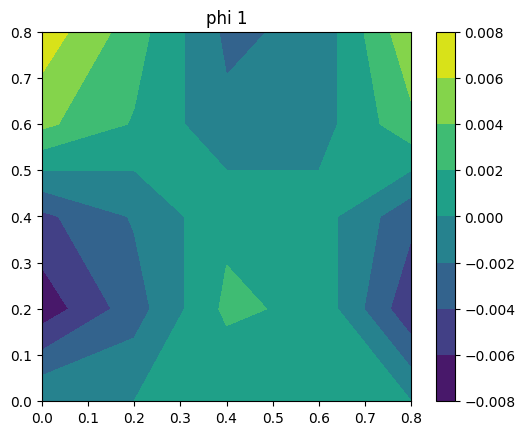

i:  2


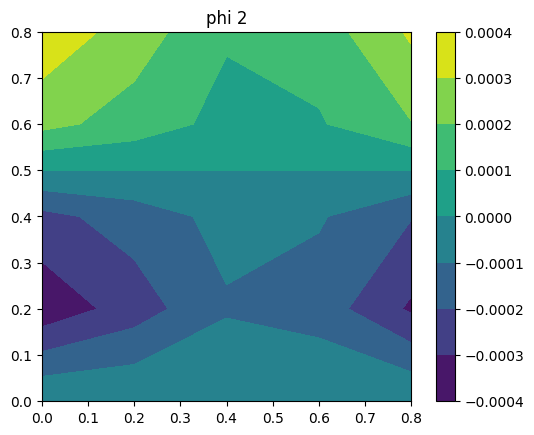

i:  3


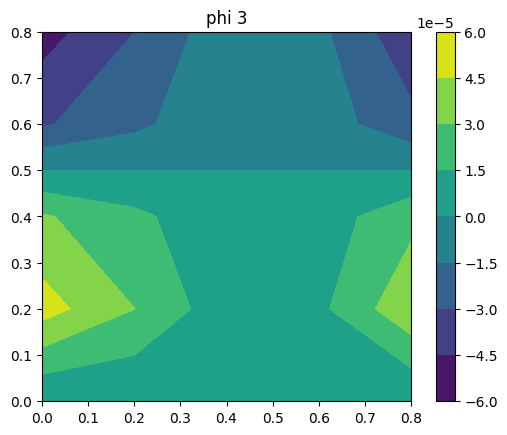

i:  4


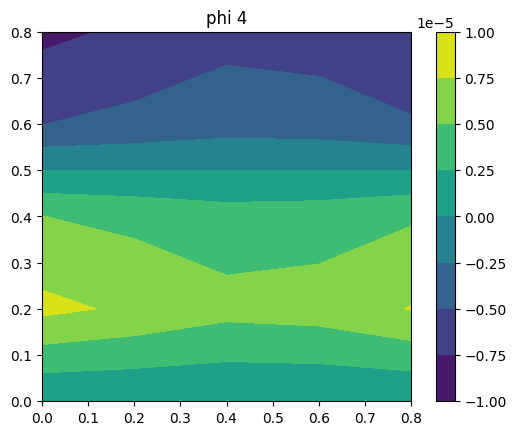

i 0


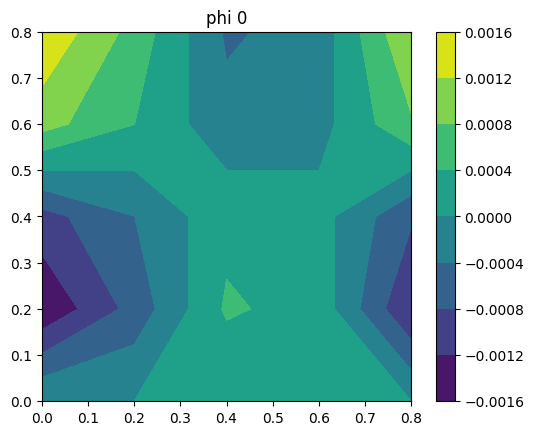

i 1


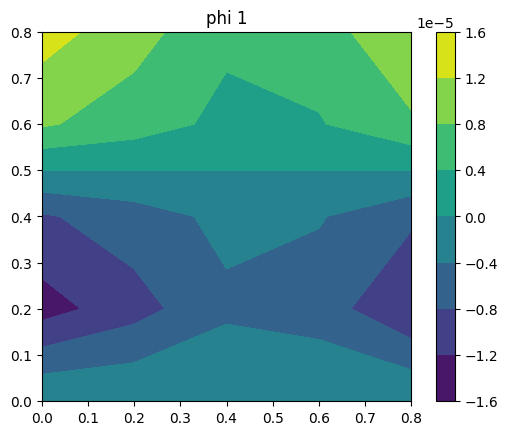

i 2


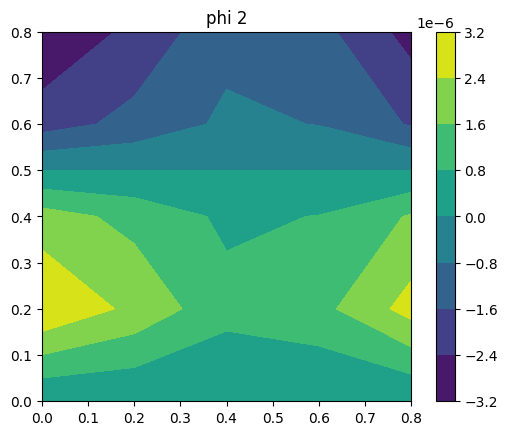

i 3


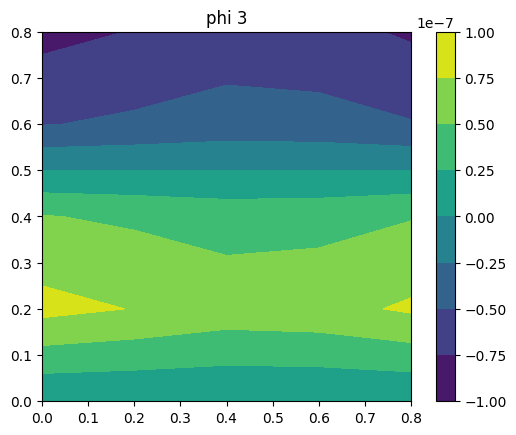

i 4


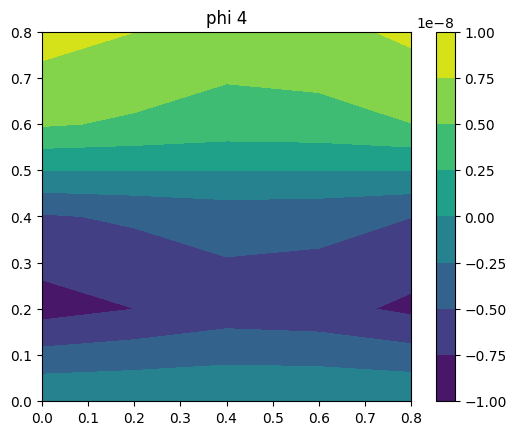

i 5


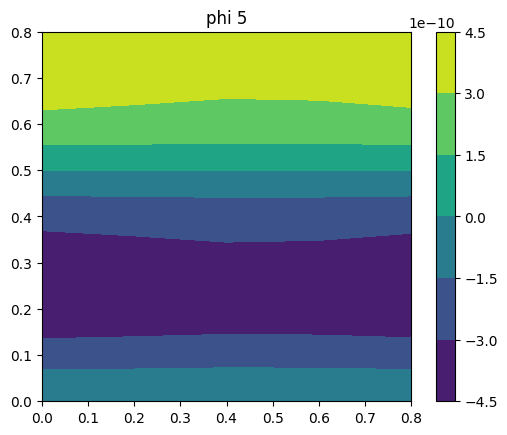

i 6


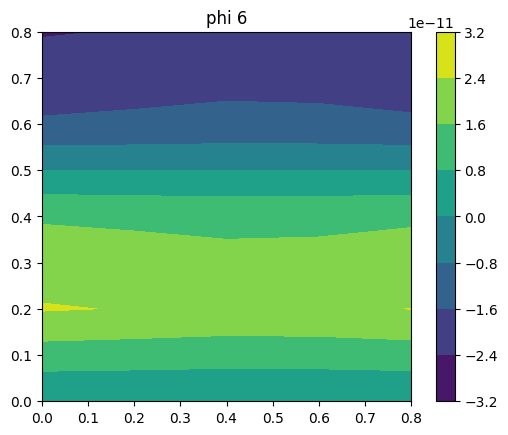

i 7


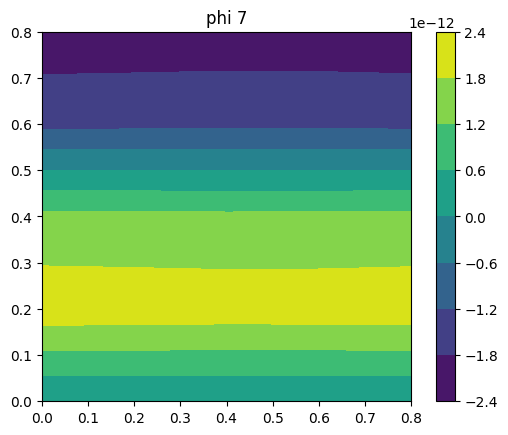

i 8


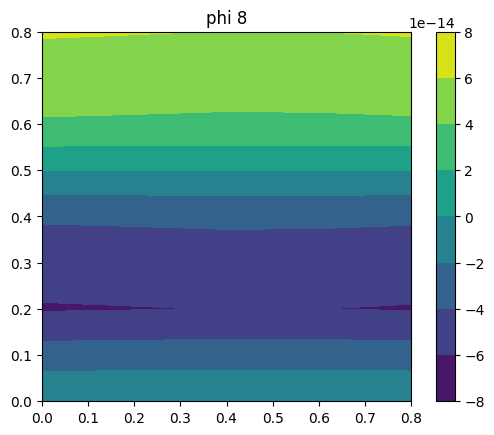

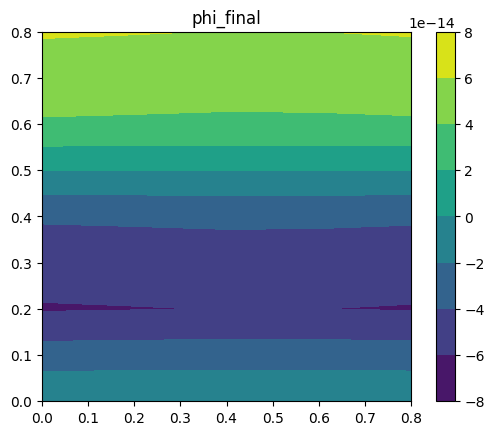

In [127]:
plotting(m, delta_x, delta_t, t_e, T, x_mod, y_mod, eta, rho, epsilon, M, C0)

In [128]:
# testing the function p_init
grad = poisson_des(m, h, 1)
print("phi_init ", phi_init_)
print(grad.toarray())

phi_init  [ 0.          0.95105652  0.58778525 -0.58778525 -0.95105652  0.
  0.29389263  0.18163563 -0.18163563 -0.29389263 -0.         -0.76942088
 -0.47552826  0.47552826  0.76942088 -0.         -0.76942088 -0.47552826
  0.47552826  0.76942088  0.          0.95105652  0.58778525 -0.58778525
 -0.95105652]
[[-100.   25.    0.    0.   25.   25.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.   25.    0.    0.    0.
     0.]
 [  25. -100.   25.    0.    0.    0.   25.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.   25.    0.    0.
     0.]
 [   0.   25. -100.   25.    0.    0.    0.   25.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   25.    0.
     0.]
 [   0.    0.   25. -100.   25.    0.    0.    0.   25.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   25.
     0.]
 [  25.    0.    0.   25. -100.    0.    0.    0.    0.   25.   

In [ ]:
def p_init(phi, mu, eta, rho, m, h):#TODO
    #LHS-grad p
    grad = poisson_des(m, h, 1)
    
    #terms involving phi and mu
    grad_phi_x = gradient_mat(m, h, np.ones(m**2), -1, 'x').dot(phi)
    grad_phi_y = gradient_mat(m, h, np.ones(m**2), -1, 'y').dot(phi)
    #print(grad_phi_x.shape)#TODO
    grad_mu_x = gradient_mat(m, h, grad_phi_x, 1, 'x').dot(mu)
    grad_mu_y = gradient_mat(m, h, grad_phi_y, 1, 'y').dot(mu)
    grad_mu_term = grad_mu_x + grad_mu_y
    poisson_mu = poisson_des(m, h, -1).dot(mu) * phi

    RHS = poisson_mu + grad_mu_term 
    #solve for p_initial
    p = spsolve(grad, RHS)
    return p

def mu_init(phi, epsilon):
    #print(poisson_des(m, h, -1).shape)
    #print(phi.shape)
    poisson_term = poisson_des(m, h, -epsilon**2).dot(phi)
    nonlinear_term = f_0_prime(phi, epsilon)
    return poisson_term + nonlinear_term


In [130]:
'''
#poisson space descretization(periodic BC)
def poisson_des(m, h, s):
    laplacian = lil_matrix((m**2, m**2))
    laplacian.setdiag(-4*np.ones(m**2)/(h**2))
    for i in range(m**2):
        if i % m != 0:
            laplacian[i,i-1] = 1/(h**2) * s
        if (i+1) % m != 0:
            laplacian[i, i+1] = 1/(h**2) * s
    for i in range(m**2 - m):
        laplacian[i, i+m] = 1/(h**2) * s
        laplacian[i+m, i] = 1/(h**2) * s

    #connecting the first and last rows
    for i in range(m):
        laplacian[i, m*(m-2)+i] = s/(h**2)
        laplacian[m*(m-1)+i, i+m] = s/(h**2)

    # Connect the first and last columns
    for i in range(m):
        laplacian[i*m, (i+1)*m-2] = s/(h**2)
        laplacian[(i+1)*m-1, i*m+1] = s/(h**2)
    
    #print(laplacian)
    return laplacian.tocsr()
'''
poisson_term = poisson_des(m, h, -epsilon**2).dot(phi_init_)
print(poisson_term)
nonlinear_term = f_0_prime(phi_init_, epsilon)
print(nonlinear_term)
mu_init_ = mu_init(phi_init_, epsilon)
print("mu_init_ ",mu_init_)

[ 3.55271368e-15 -1.40924011e+02 -8.70958289e+01  8.70958289e+01
  1.40924011e+02  8.88178420e-16 -3.84710442e+01 -2.37764129e+01
  2.37764129e+01  3.84710442e+01  0.00000000e+00  1.00718501e+02
  6.22474571e+01 -6.22474571e+01 -1.00718501e+02  0.00000000e+00
  8.42894041e+01  5.20937166e+01 -5.20937166e+01 -8.42894041e+01
  3.55271368e-15 -1.14341174e+02 -7.06667317e+01  7.06667317e+01
  1.14341174e+02]
[-0.         -0.09081782 -0.38471044  0.38471044  0.09081782 -0.
 -0.26850827 -0.1756432   0.1756432   0.26850827  0.          0.31391718
  0.36799842 -0.36799842 -0.31391718  0.          0.31391718  0.36799842
 -0.36799842 -0.31391718 -0.         -0.09081782 -0.38471044  0.38471044
  0.09081782]
mu_init_  [ 3.55271368e-15 -1.41014829e+02 -8.74805394e+01  8.74805394e+01
  1.41014829e+02  8.88178420e-16 -3.87395525e+01 -2.39520561e+01
  2.39520561e+01  3.87395525e+01  0.00000000e+00  1.01032419e+02
  6.26154555e+01 -6.26154555e+01 -1.01032419e+02  0.00000000e+00
  8.46033213e+01  5.2461

In [131]:
grad_phi_x = gradient_mat(m, h, np.ones(m**2), -1, 'x').dot(phi_init_)
grad_phi_y = gradient_mat(m, h, np.ones(m**2), -1, 'y').dot(phi_init_)
print(grad_phi_x)#TODO
grad_mu_x = gradient_mat(m, h, grad_phi_x, 1, 'x').dot(mu_init_)
grad_mu_y = gradient_mat(m, h, grad_phi_y, 1, 'y').dot(mu_init_)
print(grad_mu_x)
grad_mu_term = grad_mu_x + grad_mu_y
poisson_mu = poisson_des(m, h, -1).dot(mu_init_) * phi_init_
print(poisson_mu)

RHS = poisson_mu + grad_mu_term 

print(RHS)

[-8.04110203 -1.46946313  3.84710442  3.84710442 -0.21439178 -2.48483718
 -0.45408908  1.18882065  1.18882065 -0.0662507   6.5053882   1.18882065
 -3.11237286 -3.11237286  0.17344659  6.5053882   1.18882065 -3.11237286
 -3.11237286  0.17344659 -8.04110203 -1.46946313  3.84710442  3.84710442
 -0.21439178]
[9.58054645e+03 3.21373568e+02 2.19761386e+03 2.19761386e+03
 7.69570499e+00 8.13822405e+02 2.71909178e+01 1.86322696e+02
 1.86322696e+02 5.86587553e-01 5.55420642e+03 1.86096366e+02
 1.27333300e+03 1.27333300e+03 4.32750214e+00 4.65056492e+03
 1.55918925e+02 1.06649375e+03 1.06649375e+03 3.68513801e+00
 7.77326346e+03 2.61018686e+02 1.78393534e+03 1.78393534e+03
 6.41097672e+00]
[   -0.         19133.15053376  7324.68512326  7324.68512326
 19133.15053376    -0.          1608.27359116   615.11272158
   615.11272158  1608.27359116    -0.          9860.29979755
  3773.17934919  3773.17934919  9860.29979755     0.
  7260.9369223   2776.52009751  2776.52009751  7260.9369223
    -0.        

In [132]:
p = spsolve(grad, RHS)

RHS_test = np.array([2, 3, 4, 3, 5])
identity = np.eye(5)

test = spsolve(identity, RHS_test)
print(test)

print(grad*p)
from scipy.sparse.linalg import norm

# Compute the condition number of the sparse matrix
condition_number = norm(grad, ord=2) * norm(grad, ord=np.inf)
print("Condition number:", condition_number)

[2. 3. 4. 3. 5.]
[ 196608. -393216.  131072. -131072. -131072. -393216.  -65536.  131072.
   65536.  196608.  -65536.       0. -196608.  393216.  262144.       0.
   65536. -131072. -262144.  131072.   65536. -196608.  262144.  393216.
 -262144.]
Condition number: 36180.33988749894


/var/folders/r1/1z_0fp4d0jzbn22kmxqqcf3m0000gn/T/ipykernel_27446/2455870163.py:6: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  test = spsolve(identity, RHS_test)


In [84]:
def helper_phi_mid(m, h, delta_t, phi_n):
    #LHS 
    #scalar term
    identity = scalar_mul(1,m)
    #print(identity)
    #biharmonic term
    biharmonic_ = biharmonic(m, h, delta_t)
    print(biharmonic_)
    LHS = biharmonic_ + identity
    #RHS
    f_prime = poisson_des(m, h, delta_t).dot(f_0_prime(phi_n, epsilon))
    RHS = f_prime + phi_n
    #solve for phi_middle
    phi_mid = spsolve(LHS, RHS)
    return phi_mid

#helper function to calculate r
def helper_r(m, h, phi_n, C0):
    #f_0_n = f_0(phi_n, epsilon)
    r = np.sqrt(E(phi_n, m, h) + C0)
    #print("E ", E(phi_n, m, h))
    return r

#helper function to solve b_n
def helper_b(m, h, phi_mid, C0):
    numerator = f_0_prime(phi_mid, epsilon)
    #f_0_mid = f_0(phi_mid, epsilon)
    denominator = np.sqrt(E(phi_mid, m, h)+C0)
    return numerator / denominator

In [85]:
phi_mid = helper_phi_mid(m, h, delta_t, phi_init_)
print(phi_mid)
b_n = helper_b(m, h, phi_mid, C0)
print("b_n ", b_n)
r = helper_r(m, h, phi_init_, C0)
print("r ", r)

  (0, 30)	6.249999999999999
  (0, 18)	6.249999999999999
  (0, 12)	6.25
  (0, 28)	12.499999999999996
  (0, 10)	12.499999999999998
  (0, 5)	6.249999999999999
  (0, 3)	6.249999999999999
  (0, 25)	12.499999999999998
  (0, 7)	12.5
  (0, 2)	6.25
  (0, 24)	-499.99999999999983
  (0, 6)	-499.99999999999994
  (0, 4)	-499.99999999999983
  (0, 1)	-499.99999999999994
  (0, 0)	10012.499999999996
  (1, 31)	6.249999999999999
  (1, 19)	6.249999999999999
  (1, 13)	6.25
  (1, 26)	12.499999999999998
  (1, 8)	12.5
  (1, 3)	6.25
  (1, 25)	-499.99999999999983
  (1, 7)	-499.99999999999994
  (1, 2)	-499.99999999999994
  (1, 24)	12.499999999999998
  :	:
  (34, 34)	10018.749999999996
  (34, 29)	12.5
  (34, 28)	-499.99999999999994
  (34, 27)	12.5
  (34, 22)	6.25
  (34, 16)	6.249999999999999
  (34, 11)	12.499999999999998
  (34, 10)	-499.99999999999983
  (34, 9)	12.499999999999998
  (34, 4)	6.249999999999999
  (35, 34)	-499.99999999999994
  (35, 33)	6.25
  (35, 32)	6.249999999999999
  (35, 31)	-499.99999999999983
 